<a href="https://colab.research.google.com/github/rtheman/TimeSeries/blob/master/ARIMA_pmdarima_Covid19_AUT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARIMA

Inspired by https://alkaline-ml.com/pmdarima/usecases/sun-spots.html#fitting-a-baseline

**Dataset**: COVID-19 Active Cases of 🇦🇹 (Austria) from https://www.worldometers.info/coronavirus/

**REF**
- Matplotlib https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/04.00-Introduction-To-Matplotlib.ipynb#scrollTo=nQVfJzSfxBre

# 1.) Init. Environments & Libraries

In [ ]:
import pandas as pd
import numpy as np

! pip install pmdarima

     |████████████████████████████████| 1.5MB 2.8MB/s 
     |████████████████████████████████| 8.7MB 16.1MB/s 
     |████████████████████████████████| 2.1MB 43.4MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.20
    Uninstalling Cython-0.29.20:
      Successfully uninstalled Cython-0.29.20


## a. Mount Google Drive (G-Drive)

In [ ]:
from google.colab import drive
drive.mount('/content/g_drive')

Drive already mounted at /content/g_drive; to attempt to forcibly remount, call drive.mount("/content/g_drive", force_remount=True).


## b. Connect Google Cloud Storage (GCS)

In [ ]:
# from google.colab import auth
# auth.authenticate_user()

Paramaterize Project ID and Bucket Name

In [ ]:
# project_id = 'rleung-sandbox'
# bucket_name = 'samples_data'

# 2.) Download Data

## a. from G-Drive

Init. Parameters

In [ ]:
data_URL = "./g_drive/My Drive/Colab Notebooks/data/_Samples/"
data_FileName = "COVID19_Active_Cases_AUT.csv"
path = data_URL + data_FileName

Ingest data from G-Drive

In [ ]:
df = pd.read_csv(path, parse_dates=['Dates'], index_col='Dates')
df.tail()

,Active_Cases
Dates,
2020-04-29,2204
2020-04-30,2071
2020-05-01,1946
2020-05-02,1858
2020-05-03,1795


# 3.) Explore Data

Inspired by https://alkaline-ml.com/pmdarima/usecases/sun-spots.html#fitting-a-baseline

In [ ]:
import pandas.util.testing as tm
import pmdarima as pm
from pmdarima.datasets import load_sunspots
from pmdarima.model_selection import train_test_split
print(f"Using pmdarima {pm.__version__}")
# Using pmdarima 1.6.0

Using pmdarima 1.6.0


## a. Split dataset into Training and Validation

Take last 7-days as Validation dataset, leaving 70-days as Testing dataset.

In [ ]:
valid_len = 7
train_len = len(df) - valid_len
y_train, y_vali = train_test_split(df, train_size=train_len)
y_train.tail()

,Active_Cases
Dates,
2020-04-22,3397
2020-04-23,3094
2020-04-24,2847
2020-04-25,2655
2020-04-26,2526


## b. Visualize dataset

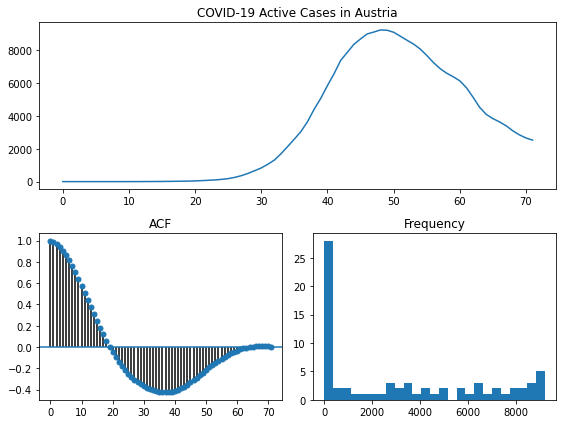

In [ ]:
from pmdarima.utils import tsdisplay

tsdisplay(y_train, lag_max=train_len-1, title="COVID-19 Active Cases in Austria", show=True)

Looking at the histogram. It is very zero-inflated. A lot of the statistical techniques used in time series modeling behave better when the data is **normally distributed**, so this may be something to look into.

# 4.) Fitting a baseline model

Before we start manipulating our data, let’s examine what would happen if we just fit a model straight out of the box:

In [ ]:
fit_base = pm.auto_arima(
    y_train,
    trace=True,
    suppress_warnings=True
)

print(fit_base.summary())

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=801.705, BIC=815.281, Time=0.154 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=1023.076, BIC=1027.602, Time=0.010 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=835.096, BIC=841.884, Time=0.031 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=956.793, BIC=963.581, Time=0.087 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=1021.967, BIC=1024.230, Time=0.008 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=812.781, BIC=824.094, Time=0.238 seconds
Near non-invertible roots for order (1, 1, 2)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=837.463, BIC=848.777, Time=0.162 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=803.443, BIC=819.281, Time=0.200 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=803.661, BIC=819.500, Tim

# 5.) Transform Data

Since we expect our model to perform better over more normal data, let’s experiment with (1.) Log transformations and the (2.) [Box-Cox transformation](https://en.wikipedia.org/wiki/Power_transform#Box%E2%80%93Cox_transformation), each of which is provided as an endogenous transformer in the Pmdarima package.

## Log Transformation

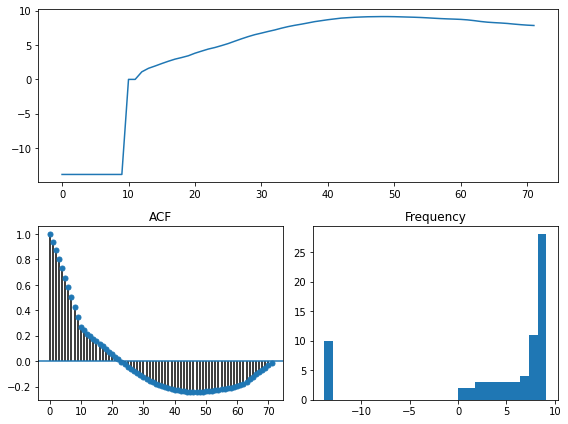

In [ ]:
from pmdarima.preprocessing import LogEndogTransformer

y_train_log, _ = LogEndogTransformer(lmbda=1e-6).fit_transform(y_train)
tsdisplay(y_train_log, lag_max=train_len-1)

In [ ]:
from scipy.stats import normaltest
normaltest(y_train_log)[1]

1.0748815918431733e-06

## Box-Cox transformation

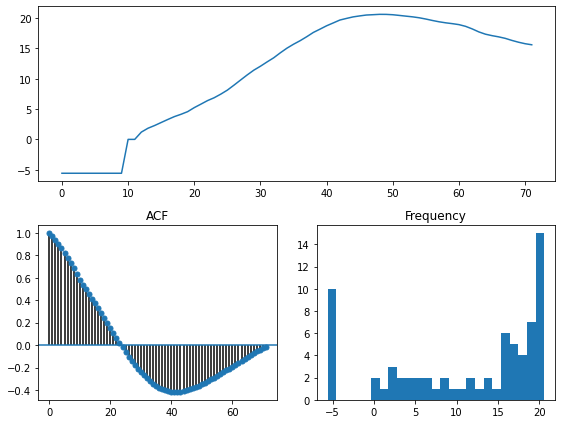

In [ ]:
from pmdarima.preprocessing import BoxCoxEndogTransformer

y_train_bc, _ = BoxCoxEndogTransformer(lmbda2=1e-6).fit_transform(y_train)
tsdisplay(y_train_bc, lag_max=train_len-1)

In [ ]:
normaltest(y_train_bc)[1]

0.0018850861975009633

# 6.) Fitting a transformed model

Pmdarima implements a scikit-learn-esque pipeline used to chain transformations and estimators together. Using this, we can centralize the entire transformer/model fit into one metaestimator:

## a. Log Transformation

In [ ]:
from pmdarima.pipeline import Pipeline

fit_log = Pipeline([
    ('log', LogEndogTransformer(lmbda=1e-6)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True
                           )
    )
])

fit_log.fit(y_train)

print(fit_log.summary())

ValueError: ignored

## b. Box-Cox Transformation

In [ ]:
fit_boxcox = Pipeline([
    ('boxcox', BoxCoxEndogTransformer(lmbda2=1e-6)),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True
                           )
    )
])

fit_boxcox.fit(y_train)

print(fit_boxcox.summary())

Performing stepwise search to minimize aic
Fit ARIMA(2,2,2)x(0,0,0,0) [intercept=True]; AIC=158.827, BIC=172.318, Time=0.354 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=196.955, BIC=201.452, Time=0.018 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=168.785, BIC=175.531, Time=0.045 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=154.844, BIC=161.590, Time=0.155 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=194.956, BIC=197.204, Time=0.011 seconds
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=156.142, BIC=165.136, Time=0.099 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=156.318, BIC=165.312, Time=0.076 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=157.804, BIC=169.047, Time=0.124 seconds
Total fit time: 0.889 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   72
Model:               SARIMAX(0, 2, 1)   Log Like

# 7.) Forecast

Forecast the next 7-days

In [ ]:
# Forecast
import numpy as np

model = fit_base
forecast, conf_int = model.predict(n_periods=valid_len, return_conf_int=True)
print("\nForecasts:")
print(forecast)


Forecasts:
[2369.35513649 2246.73405963 2114.09147352 2005.42122824 1892.57297133
 1797.01042934 1700.70606692]


## a. Visualize Forecast

### Set-up Plots

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

! pip install mplcursors
import mplcursors

%matplotlib inline

plt.figure()  # create a plot figure
mpl.rcParams['figure.figsize'] = (20, 15)

<Figure size 432x288 with 0 Axes>

### Visualize Goodness of Fit

In [ ]:
# Visualize goodness of fit
in_sample_forecast, in_sample_confint = model.predict_in_sample(exogenous=None, return_conf_int=True)

### Actual vs. Forecast w/ Test Dataset

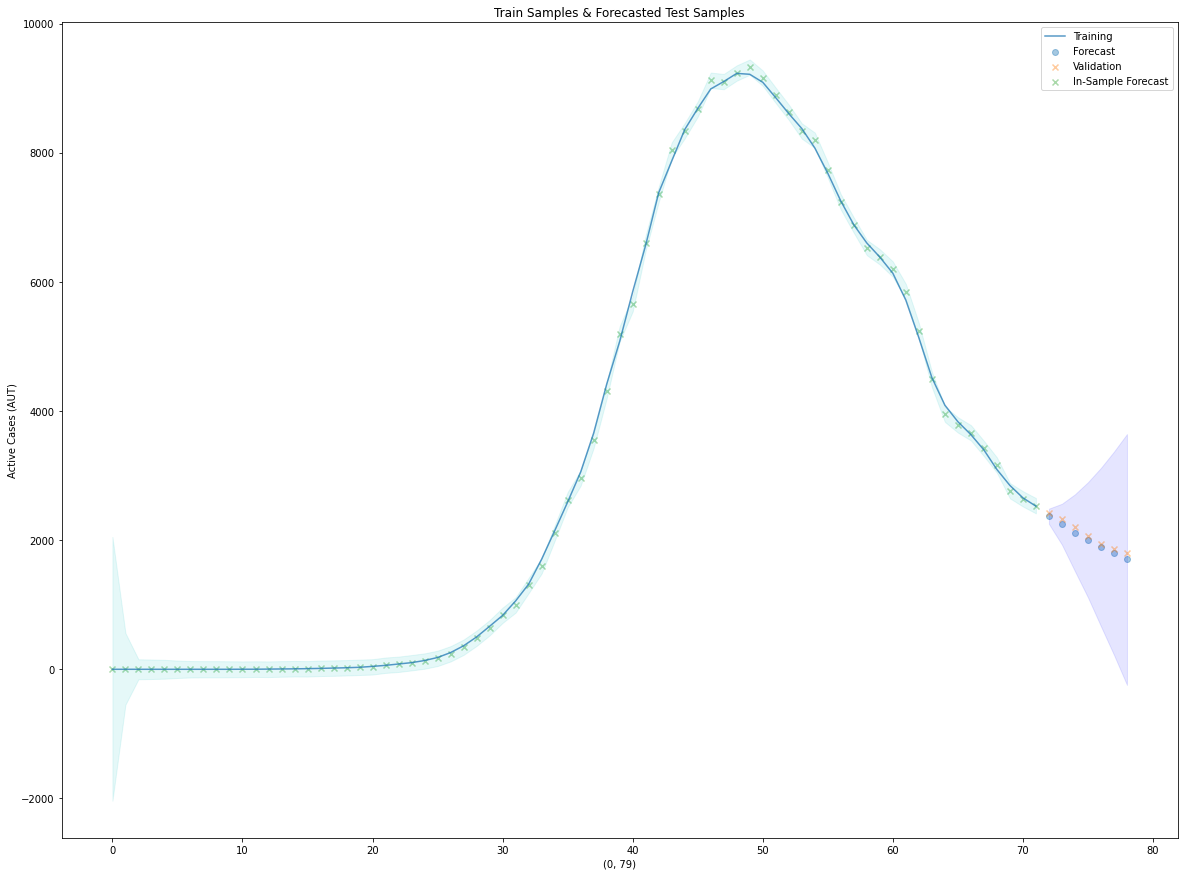

In [ ]:
# Now plot the results and the forecast for the test set
x_axis = np.arange(y_train.shape[0] + forecast.shape[0])

# Training data
plt.plot(x_axis[:y_train.shape[0]], y_train, alpha=0.75, label='Training')
# Forecast from ARIMA model
plt.scatter(x_axis[y_train.shape[0]:], forecast, alpha=0.4, marker='o', label='Forecast')
plt.fill_between(x_axis[-forecast.shape[0]:], conf_int[:, 0], conf_int[:, 1], alpha=0.1, color='b')
# Validation data
plt.scatter(x_axis[y_train.shape[0]:], y_vali, alpha=0.4, marker='x', label='Validation')
# In-Samples Forecast
plt.scatter(x_axis[:in_sample_forecast.shape[0]], in_sample_forecast, alpha=0.4, marker='x', label="In-Sample Forecast")
plt.fill_between(x_axis[:in_sample_forecast.shape[0]], in_sample_confint[:, 0], in_sample_confint[:, 1], alpha=0.1, color='c')

plt.title('Train Samples & Forecasted Test Samples')
plt.legend()
plt.xlabel((0, x_axis.shape[0]))
plt.ylabel('Active Cases (AUT)')
mplcursors.cursor(hover=True)
# mplcursors.cursor()

### Comparison btw Actuals & Forecast

In [ ]:
df_fcast = y_vali.copy()
df_fcast['Forecast'] = forecast
df_fcast['difference'] = df_fcast['Forecast'] - df_fcast['Active_Cases']
df_fcast

,Active_Cases,Forecast,difference
Dates,,,
2020-04-27,2425,2369.355136,-55.644864
2020-04-28,2324,2246.734060,-77.265940
2020-04-29,2204,2114.091474,-89.908526
2020-04-30,2071,2005.421228,-65.578772
2020-05-01,1946,1892.572971,-53.427029
2020-05-02,1858,1797.010429,-60.989571
2020-05-03,1795,1700.706067,-94.293933


## b. Update Forecast

### Add the actual samples (validation dataset) to the model and crate NEW forecast

In [ ]:
fit_base.update(y_vali)

model = fit_base

new_forecast, new_conf_int  = model.predict(n_periods=valid_len, return_conf_int=True)
print("\nNew Forecast:")
print(new_forecast)


New Forecast:
[1754.35843381 1699.54255508 1662.3856553  1617.82414742 1584.81253268
 1548.30310585 1519.56218237]


### Actual vs (New) Forecast

Text(0, 0.5, 'Active Cases (AUT)')

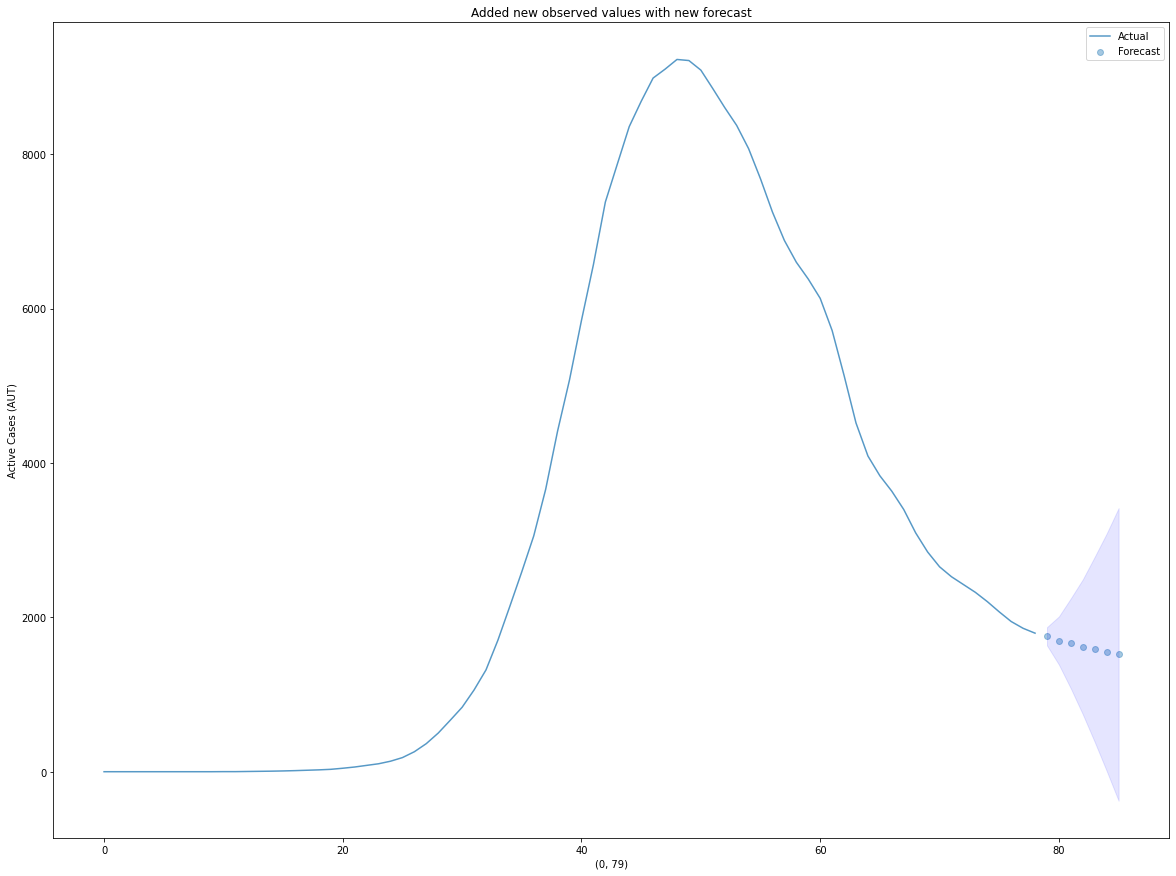

In [ ]:
# Now Plot results and the new forecast
new_x_axis = np.arange(df.shape[0] + valid_len)

# Training (Actual) data
plt.plot(new_x_axis[:df.shape[0]], df, alpha=0.75, label='Actual')
# New Forecast data
plt.scatter(new_x_axis[df.shape[0]:], new_forecast, alpha=0.4, marker='o', label='Forecast')
plt.fill_between(new_x_axis[-forecast.shape[0]:], new_conf_int[:, 0], new_conf_int[:, 1], alpha=0.1, color='b')

plt.title('Added new observed values with new forecast')
plt.legend()
plt.xlabel((0, x_axis.shape[0]))
plt.ylabel('Active Cases (AUT)')

In [ ]:
import datetime

start_date = df.index[-1]
start_date += datetime.timedelta(days=1)

df_forecast_index = pd.date_range(start_date, periods=7, freq='D')
# df_forecast_index

data = {'Active_Cases':new_forecast}
# data

df_forecast = pd.DataFrame(data, index = df_forecast_index)
df_forecast

,Active_Cases
2020-05-04,1754.358434
2020-05-05,1699.542555
2020-05-06,1662.385655
2020-05-07,1617.824147
2020-05-08,1584.812533
2020-05-09,1548.303106
2020-05-10,1519.562182
